In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import librosa
from tqdm import tqdm
from scipy.stats import skew
import seaborn as sns
from collections import Counter
import torchaudio
import pretty_midi
import os
from librosa.feature import rhythm
import random
import torch.nn.functional as F
from torchmetrics import F1Score

# Music waveform analysis and trascription

## Project Overview

The purpose of this project is to analyse the soundwaves of different music types, focusing on classical music, use deep learning to extract important features and transform the music into notes, use machine learning to cluster different genres. In order to have more structure in the project I am going to start analyzing one of the datasets and trying to perform some analysis and operations on that. After that I am going to do the same on the other one with modern music. After each analysis I will run the waves through a model to try and predict outcomes.


# Classical music waveforms EDA

To begin with, I am going to use a dataset that contains classical music. It is probably the easiest to transcribe into notes. We are going to begin by getting some data. The source I am using is from Mini MusicNet since the big MusicNet contains a huge amount of data that would require a lot of computational power and time.

Let us explain how our data looks like. We have a lot of data points, 82,500 samples to be exact. Each of them has 4096 features. We expect those 4096 features to be the **raw amplitudes.** To make it simpler:

- **Number of samples:** 82,500  
- **Input features per sample:** 4,096 (representing audio features)  
- **Output labels per sample:** 128 (binary indicators for each note)  
- **Duration per sample:** 256 milliseconds  
- **Sampling rate:** 16,000 Hz  


In [2]:

Xtrain = np.load('audio-train.npy')
Ytrain = np.load('labels-train.npy')
Xvalid = np.load('audio-valid.npy')
Yvalid = np.load('labels-valid.npy')
Xtest = np.load('audio-test.npy')
Ytest = np.load('labels-test.npy')

Now that we have loaded the data we can give an example of how the raw data looks like. **The data we are using are 9ms recording.**

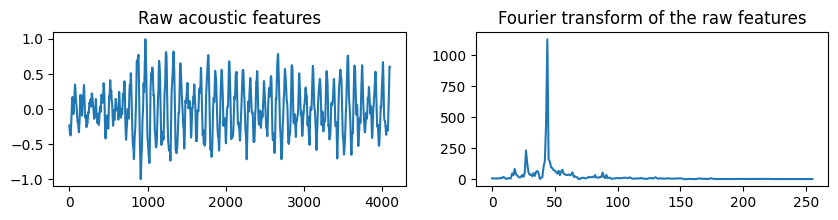

In [3]:
fig, ax = plt.subplots(1, 2, figsize=(10,2))
ax[0].set_title('Raw acoustic features')
ax[0].plot(Xtrain[2])
ax[1].set_title('Fourier transform of the raw features')
ax[1].plot(np.abs(np.fft.rfft(Xtest[2])[0:256])) # clip to 256 for the interval of 0Hz to 1kHz

What we just did was to take one of the files we have, show it's raw version and then the fourier transform. 
- **Left plot (Raw acoustic features):**  
  This shows the raw audio waveform values over time for one sample from `Xtrain[0]`. The x-axis represents the time steps or audio samples (ranging approximately from 0 to 4100), and the y-axis shows the amplitude of the audio signal at each time step (ranging from about -1 to 1). The waveform represents how the air pressure (sound wave) changes over time in the audio clip.

- **Right plot (Fourier Transform of the raw features):**  
  This shows the magnitude of the frequency components obtained by applying the Fast Fourier Transform (FFT) to the raw audio waveform.  
  The x-axis represents frequency bins (up to 256 in this clipped visualization), and the y-axis represents the amplitude (strength) of each frequency component. The FFT decomposes the time-domain signal into its frequency components, revealing which frequencies are present in the audio and their intensities.

**Summary:**  
- The raw waveform (left) shows how the sound varies over time.  
- The Fourier transform (right) shows the distribution of frequencies that make up the sound.  
These two views provide complementary insights into the audio: time domain vs frequency domain.


This means for each bin:
$$
f = \frac{\text{bin\_index} \times f_s}{N}
$$

where:  
- $ f $ is the frequency corresponding to the FFT bin,  
- $ \text{bin\_index} $ is the index of the FFT bin (0, 1, 2, $\ldots$),  
- $ f_s $ is the sampling rate (in Hz),  
- $ N $ is the FFT size (number of samples).

**Example:**  
If the sampling rate $ f_s = 16,000 $ Hz, FFT size $ N = 4,096 $, and the bin index is 50, then the frequency is:

$$
f = \frac{50 \times 16,000}{4,096} \approx 195.31 \text{ Hz}
$$


For a reference let us see which note that would be on the guitar. We see that the open G string is relatively close to the frequency we had. This means that the frequency that was available in this small sample was the G note.
<img src="https://musicmaster.in/music-tools/tuner/string-freq.png" alt="Guitar Tuning Frequencies" width="400"/>

Now that we are familiar with what the waveforms look like we are going to go thorugh some simple analysis of the data so we have an idea of what we are working with.

In [4]:
print("Xtrain shape:", Xtrain.shape)
print("Ytrain shape:", Ytrain.shape)
print("Xtest shape:", Xtest.shape)
print("Ytest shape:", Ytest.shape)

Xtrain shape: (62500, 4096)
Ytrain shape: (62500, 128)
Xtest shape: (10000, 4096)
Ytest shape: (10000, 128)


In [5]:
print("Number of active notes per sample (mean):", np.mean(np.sum(Ytrain, axis=1)))
print("Label sparsity:", np.mean(Ytrain))  # Proportion of 1s in labels

Number of active notes per sample (mean): 2.941808
Label sparsity: 0.022982875


What we just did was calculate the average number of active notes per sample. We achieved this by summing the columns of `Ytrain`, which is multi-one-hot encoded: each entry is `1` if a note is active in a given sample and `0` otherwise.

Before we keep on with the preprocessing of the data I am going to run some analysis on the frequencies we got.

In [6]:
print("Xtrain dtype:", Xtrain.dtype)
print("Ytrain dtype:", Ytrain.dtype)

Xtrain dtype: float32
Ytrain dtype: float64


We see that the Xtrain and the Ytrain are of different types. We are going to change that so that we can pass them more safely to our model later on.

In [7]:
Ytrain = Ytrain.astype(np.float32)

In [8]:
print("Sample Xtrain[0]:", Xtrain[0])
print("Sample Ytrain[0]:", Ytrain[0])

Sample Xtrain[0]: [-0.01537969 -0.0221083  -0.03524511 ...  0.16404998  0.17494392
  0.19032362]
Sample Ytrain[0]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


We can also see the relationship between played and unplayed notes.

Unique labels and counts: {np.float32(0.0): np.int64(7816137), np.float32(1.0): np.int64(183863)}


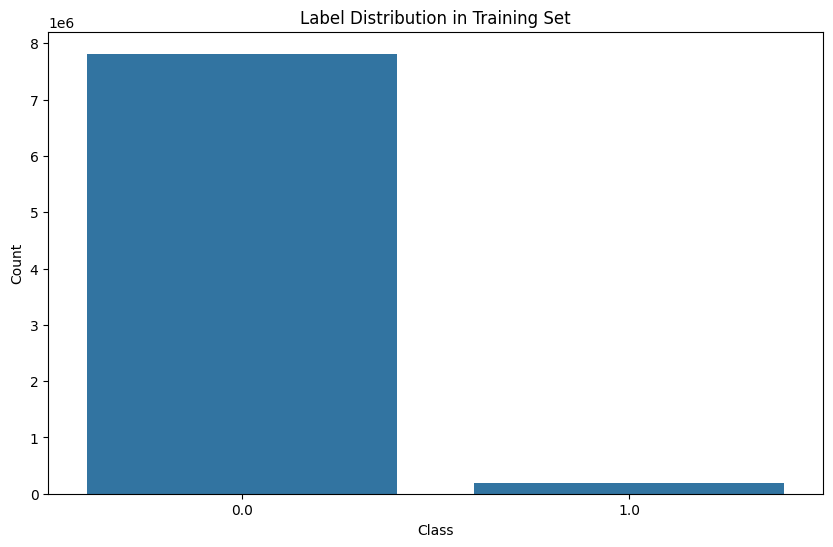

In [9]:


unique, counts = np.unique(Ytrain, return_counts=True)
print("Unique labels and counts:", dict(zip(unique, counts)))

# Visualize label distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=Ytrain.ravel())
plt.title("Label Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

This gives us some important information telling us that the dataset is highly inbalanced. **In this case it is not reasonable and logical to under or oversample since it will affect the results.** We will deal with this problem later on.

#### Checking normality of data
I am going to see the mean, std, min and max of the `Xtrain` dataset in order to know if any normalization might be necessary before working with model.

In [10]:
print("Xtrain stats - Mean:", np.mean(Xtrain), "Std:", np.std(Xtrain), 
      "Min:", np.min(Xtrain), "Max:", np.max(Xtrain))

Xtrain stats - Mean: -8.922857e-06 Std: 0.34472543 Min: -1.0 Max: 1.0


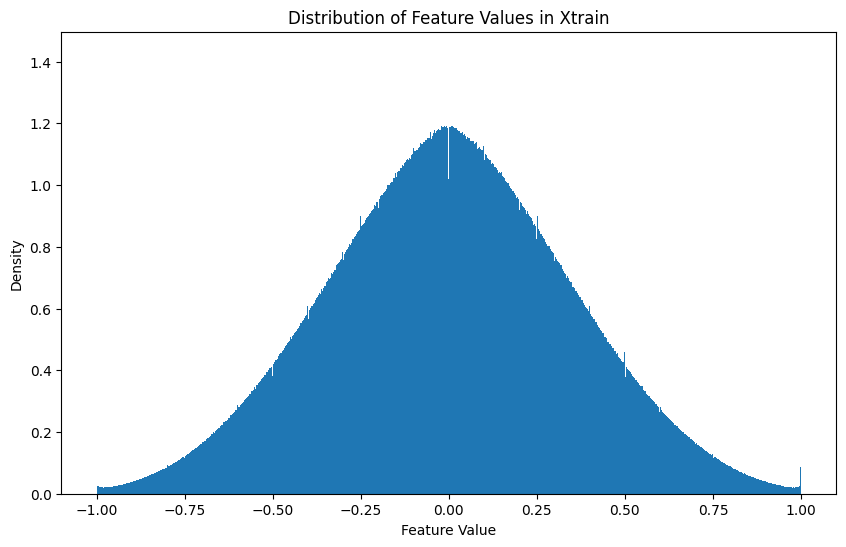

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(Xtrain.flatten(), bins=1000, density=True)
plt.title("Distribution of Feature Values in Xtrain")
plt.xlabel("Feature Value")
plt.ylabel("Density")
plt.show()

What we just took a look at is the distribution of the features values in the Xtrain. We can easily see that they are equally distributed with a mean close to 0 and a standartd deviation of 0.34 which is something very standard. This is absolutely expected normalized audio data.

## Mean amplitude, variance, skewness
To gain some more information about the waveform characteristics in our dataset, I will analyze three fundamental statistical properties: **mean amplitude, variance, and skewness** for both the training and validation sets. These metrics provide insights into the overall structure and distribution of the audio signals. The mean amplitude indicates the average energy level of the waveforms, variance reflects the dynamic range or intensity fluctuations, and skewness reveals the asymmetry in the signal distribution. 

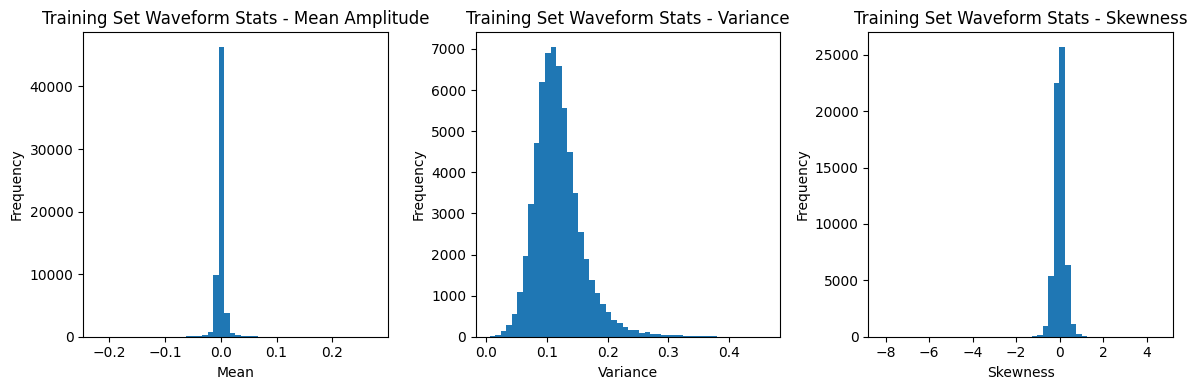

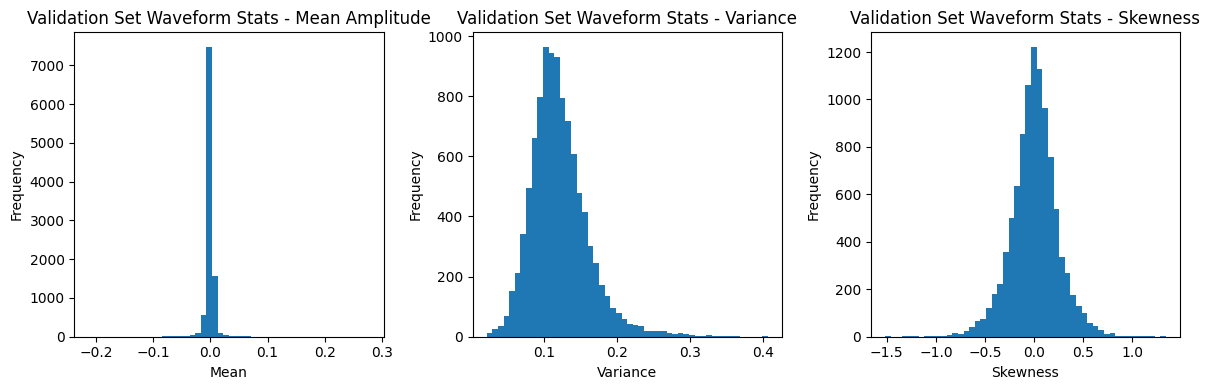

In [12]:
def plot_waveform_stats(X, title):
    means = np.mean(X, axis=1)
    variances = np.var(X, axis=1)
    skewness = skew(X, axis=1)
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.hist(means, bins=50)
    plt.title(f"{title} - Mean Amplitude")
    plt.xlabel("Mean")
    plt.ylabel("Frequency")
    
    plt.subplot(1, 3, 2)
    plt.hist(variances, bins=50)
    plt.title(f"{title} - Variance")
    plt.xlabel("Variance")
    plt.ylabel("Frequency")
    
    plt.subplot(1, 3, 3)
    plt.hist(skewness, bins=50)
    plt.title(f"{title} - Skewness")
    plt.xlabel("Skewness")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

plot_waveform_stats(Xtrain, "Training Set Waveform Stats")
plot_waveform_stats(Xvalid, "Validation Set Waveform Stats")

### Moments
1. In the first plot the narrow distribution around 0 indicates that the audio samples are likely preprocessed, which is standard for machine learning tasks. However, the extreme concentration suggests limited variability in amplitude. Pretty much the same is seen with the validation set, with a lower freqency of course, since it contains less samples.
2. The variance distribution has a broad peak between 0.1 and 0.2, with a high frequency in this range, dying off as variance increases beyond 0.3. This shows that most samples have moderate variability in amplitude, which is typical for audio with dynamic changes.
3. The last plot showing skewness measures the asymmetry of the amplitude distribution. A value near 0 indicates a symmetric distribution, which is expected if the audio is well-balanced. The positive tail suggests some samples have right-skewed distributions, possibly due to brief loud events or clipping, but the dominance of 0 skewness aligns with normalized data.

## Absolute mean
In the last task we saw that the mean of the amplitute is around zero suggesting well-distributed data. Now however we will look at one more thing, which is the absolute mean.

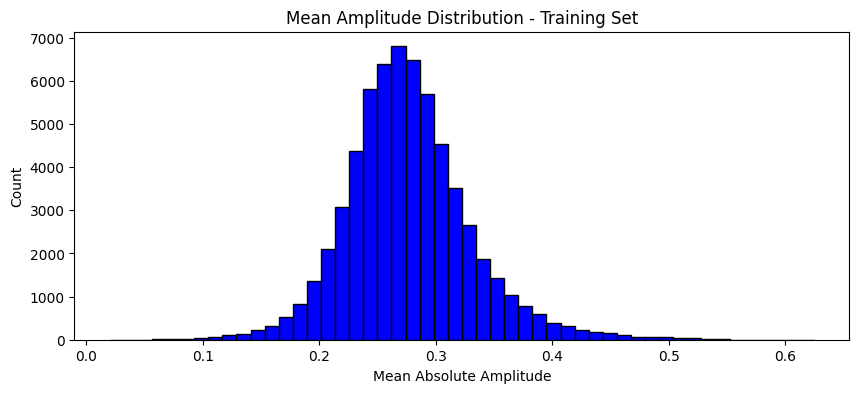

Mean of mean amplitudes: 0.27614978
Mean of std amplitudes: 0.3401256
Mean of peak-to-peak: 1.8715175


In [13]:

mean_amplitudes = np.mean(np.abs(Xtrain), axis=1)
std_amplitudes = np.std(Xtrain, axis=1)
peak_to_peak = np.ptp(Xtrain, axis=1)


plt.figure(figsize=(10, 4))
plt.hist(mean_amplitudes, bins=50, color='blue', edgecolor='black')
plt.title('Mean Amplitude Distribution - Training Set')
plt.xlabel('Mean Absolute Amplitude')
plt.ylabel('Count')
plt.savefig('amplitude_dist_training.png')
plt.show()

# Print basic statistics
print("Mean of mean amplitudes:", np.mean(mean_amplitudes))
print("Mean of std amplitudes:", np.mean(std_amplitudes))
print("Mean of peak-to-peak:", np.mean(peak_to_peak))


Again, from this analysis, we can say that our data is acting as expected, showing consistent amplitude ranges, variability, and dynamic range across samples - indicating good signal quality and no major anomalies that would require immediate preprocessing adjustments.

## Analyzing energy

### What is RMS?

For the next part we re going to look at something a little bit more complex. **The RMS measure of the average power or intensity of an audio signal over time.** It is calculated with the formula: $$ \text{RMS} = \sqrt{\frac{1}{N}\sum_{i=1}^N x_i^2}$$
where:
- $x(t)$ is a waveform
- $N$ is the number of samples

Before we go further, I am going to explain frame length and hop length which are necessary parameters that we are going to deal with. When we want to calculate the RMS it is not only necessary to have the waveforms and the number of samples. We need to decide how we are going to group different frames.

### Frame length and hop length

**Frame Length:** The number of samples in each analysis window (frame) for computing RMS energy. It determines the time duration of each RMS measurement.

Formula: $$\text{Duration of frame} =  \frac{\text{frame\_length}}{\text{sampling\_rate}} $$

For `frame_length=256` at 16,000 Hz: $ \frac{256}{16000} = 0.016 \, \text{seconds} = 16 \, \text{ms} $.
Larger frame lengths smooth the RMS energy, capturing broader trends but potentially missing rapid changes (e.g., note onsets). Smaller frames provide finer temporal resolution but may be noisy.


**Hop Length:** The number of samples between the start of consecutive frames. It controls the overlap between frames and the temporal resolution of the output.

Formula: $$\text{Hop duration} =  \frac{\text{hop\_length}}{\text{sampling\_rate}} $$

For `hop_length=64` at 16,000 Hz: $ \frac{64}{16000} = 0.004 \, \text{seconds} = 4 \, \text{ms} $.
Smaller hop lengths increase overlap (more frames, higher resolution) but increase computation. Larger hop lengths reduce overlap, potentially missing short events.


**Output:** For a 4,096-sample waveform, `librosa.feature.rms` produces a time series of RMS values. Number of frames:
$$\text{Number of frames} = \left\lfloor \frac{\text{signal\_length} - \text{frame\_length}}{\text{hop\_length}} \right\rfloor + 1$$
With frame_length=256, hop_length=64, and signal length 4,096:
$$\text{Number of frames} = \left\lfloor \frac{4096 - 256}{64} \right\rfloor + 1 = \left\lfloor \frac{3840}{64} \right\rfloor + 1 = 60 + 1 = 61 \, \text{frames}$$
Each frame represents 16 ms, with a new frame every 4 ms

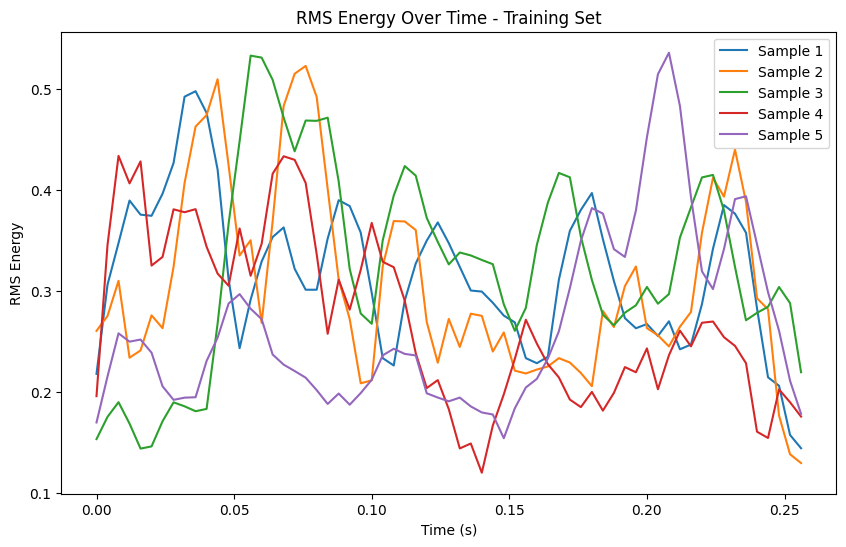

In [14]:
sr = 16000
frame_length = 256  # 16 ms
hop_length = 64    # 4 ms

# Compute frame-based RMS for first 5 samples
all_rms = []
plt.figure(figsize=(10, 6))
for i in range(5):
    rms = librosa.feature.rms(y=Xtrain[i], frame_length=frame_length, hop_length=hop_length)[0]
    all_rms.append(rms)
    times = np.arange(len(rms)) * hop_length / sr
    plt.plot(times, rms, label=f'Sample {i+1}')

plt.title('RMS Energy Over Time - Training Set')
plt.xlabel('Time (s)')
plt.ylabel('RMS Energy')
plt.legend()
plt.show()
plt.close()


In our context we need to see what that means.
- High RMS values indicate loud sections (forte piano).
- Low RMS values suggest soft passages or silences.
- Sudden RMS increases often align with note onsets, which could actually be useful for transcription.

## Lower frequency tendency in classical music
![Frequency of instruments](https://slideplayer.com/slide/16845789/97/images/13/Frequency+of+Instruments.jpg)

It is expected for classical music to exhibit a lower overall frequency profile compared to modern genres like rock, metal, or pop. This trend is primarily due to the nature and frequency ranges of the instruments typically used in classical compositions.
Instrument Frequency Ranges

- **Double** Bass: 41 Hz – 294 Hz (E1 – D3)
- **Cello**: 65 Hz – 659 Hz (C2 – E4)
- **Viola**: 131 Hz – 1,319 Hz (C3 – G5)
- **Violin**: 196 Hz – 3,136 Hz (G3 – G7)
- **Bassoon**: 58 Hz – 587 Hz (B♭0 – D4)
- **Contrabassoon**: 29 Hz – 233 Hz (B♭0 – B♭2)
- **Tuba**: 49 Hz – 587 Hz (B♭0 – D4)
- **Trombone**: 82 Hz – 698 Hz (E2 – F4)
- **French** Horn: 78 Hz – 932 Hz (B♭1 – A4)
- **Trumpet**: 164 Hz – 1,048 Hz (E3 – C5)
- **Flute**: 262 Hz – 2,093 Hz (C4 – C7)
- **Piccolo**: 523 Hz – 4,186 Hz (C5 – C8)
- **Oboe**: 233 Hz – 1,568 Hz (B♭3 – G6)
- **Clarinet**: 164 Hz – 1,397 Hz (E3 – F6)
- **Piano**: 27 Hz – 4,186 Hz (A0 – C8)
- **Harp**: 32 Hz – 3,136 Hz (C1 – G7)

As we can observe, many of these classical instruments occupy the lower to mid-frequency spectrum. Instruments like the double bass, contrabassoon, tuba, and cello are fundamentally low-pitched and form the bass foundation of orchestral music. Even higher-pitched instruments, such as the violin or flute, often play within moderate frequency ranges, and their upper limits are rarely sustained except for expressive or soloistic purposes.

Furthermore, when we encounter higher frequencies in these instruments, they are often not from the fundamental pitches but from overtones or harmonics. These overtones are naturally occurring vibrations at integer multiples of the fundamental frequency and are responsible for the richness and color of the sound, rather than significantly altering the musical pitch range itself.

To better visualize this trend, I will now show a plot comparing the frequency ranges of various classical instruments, highlighting the overall tendency toward the lower end of the audible spectrum.

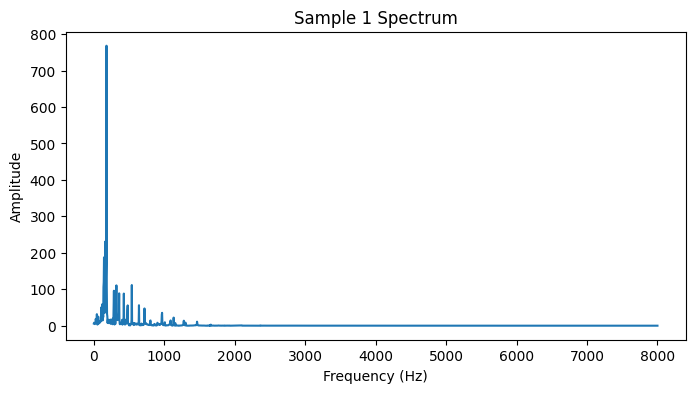

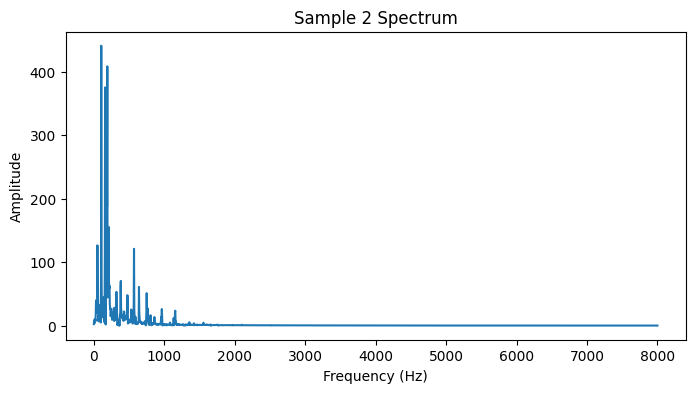

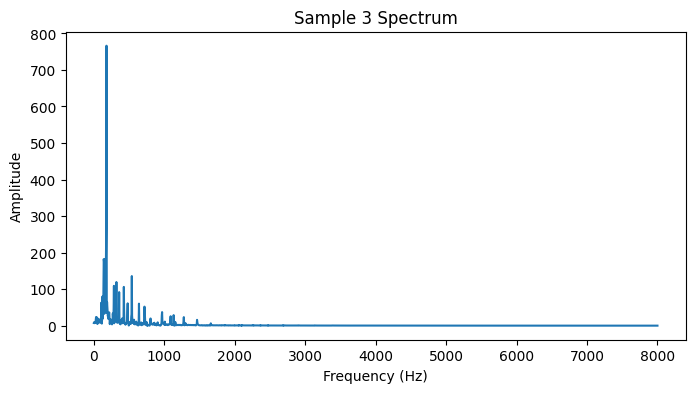

In [15]:
def plot_spectrum(waveform, sr=16000, title="Spectrum"):
    fft = np.abs(np.fft.rfft(waveform))
    freqs = np.fft.rfftfreq(len(waveform), 1/sr)
    plt.figure(figsize=(8, 4))
    plt.plot(freqs, fft)
    plt.title(title)
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude")
    plt.show()

# Example for a few samples
for i in range(3):
    plot_spectrum(Xtrain[i], title=f"Sample {i+1} Spectrum")

The frequency spectra for Samples 1, 2, 3 reveal a consistent pattern where the majority of the amplitude is concentrated below 1000 Hz, with a sharp peak near 0 Hz and a rapid decline in energy as frequencies increase toward 8000 Hz. This distribution aligns with our hypothesis that classical music exhibits a dominance of lower frequencies, reflecting the fundamental ranges of orchestral instruments . The minimal energy above 1000 Hz further supports the idea that the dataset captures the characteristic low-frequency richness of classical music.

## Working with spectograms

Firstly, let us explain what a spectrogram is. A spectrogram is a visual representation of the spectrum of frequencies in a signal as they vary over time. It is widely used in audio analysis to understand how the energy of different frequency components changes throughout a recording.

When reading spectrograms, we typically interpret three key components:

**X-axis: Represents time** — showing when events occur in the signal.

**Y-axis: Represents frequency** — showing which frequencies are present.

**Color (or intensity)**: Represents the amplitude or strength of each frequency at a given moment. Brighter areas indicate higher intensity (louder sound), while darker areas indicate lower intensity.

Let us go over an example:

<img src="https://splice.com/blog/wp-content/uploads/2023/04/image1.png" alt="Example" width="500"/>
In this picture, we can see the spectrogram of a bass guitar. Notice how most of the energy is concentrated in the lower frequency range (lower part of the Y-axis), which is typical for bass instruments. The horizontal lines show the sustained notes, and their thickness or brightness indicates their strength. You can also observe subtle variations in intensity over time, reflecting the dynamics and articulation of the playing.

### Spectograms in deep learning models
When we need to create a model that is able to distinguish different notes(i.g., be able to detect frequencies at a specific time) this means that we need to give the model something from which it might extract more meaningful features. Spectograms allow us to do exatcly that especially combined with CNN. In our case we are going to use a specific type of spectograms: **Mel spectograms.** The interesting thing about those type of spectograms is that they use a scale that aims to mimic how people perceive pitch. I am going to transform the raw data that we have to Mel spectograms. **The knowledge we have of hop lengths and frame lengths is also applicable here**

![Spectogram](https://tse3.mm.bing.net/th/id/OIP.ll0gfr1Z05Sjh6rlHuKkZwHaC0?r=0&rs=1&pid=ImgDetMain&o=7&rm=3)

Before building the spectograms for each of the samples I would like to take a look at the spectograms of a couple of samples in order to see if **the notes played are played melodically or harmonically which is going to affect our model later on.** I am going to cherry pick 4 samples from the train dataset, each containing a different number of played notes. For transforming from midi to Hz will also use the formula:
$$ f = 440 \times 2^{\frac{m - 69}{12}}$$

Also I am **not** going to use mel spectogram in otder to get the linear transformation of the Hz.

[Sample 10] Active MIDI notes: [38 50]
[Sample 10] Frequencies (Hz): [ 73.4 146.8]


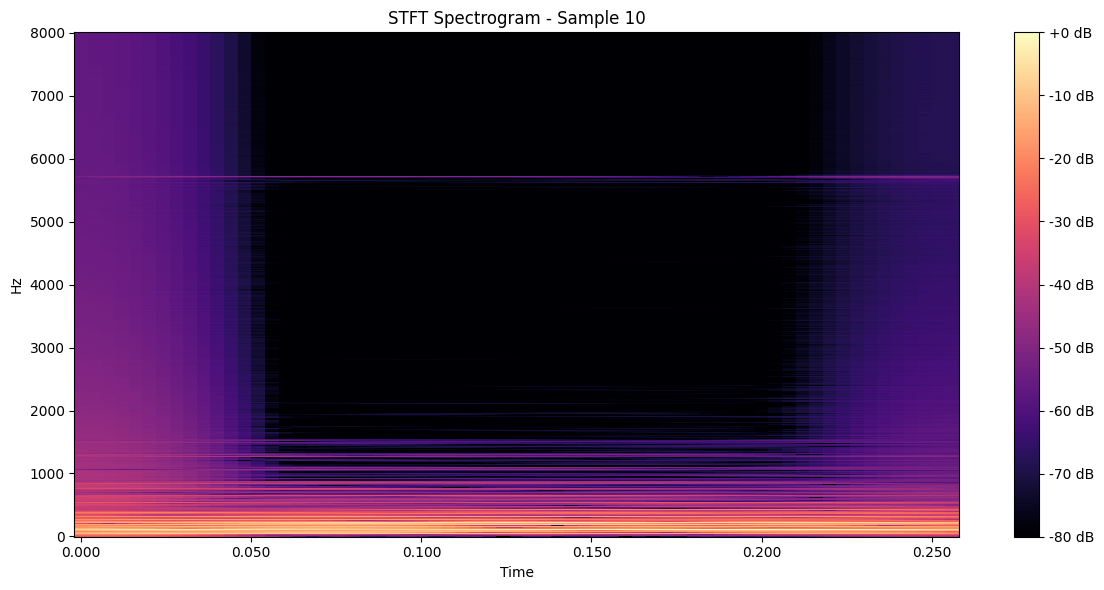

[Sample 11] Active MIDI notes: [62 65 69 74]
[Sample 11] Frequencies (Hz): [293.7 349.2 440.  587.3]


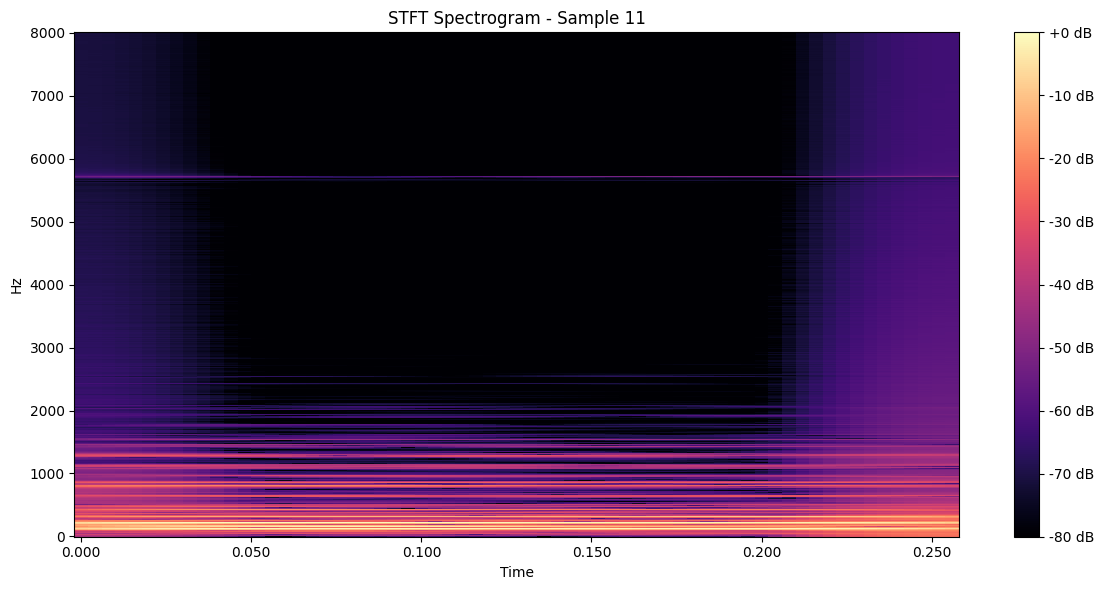

[Sample 19] Active MIDI notes: [67 70 82]
[Sample 19] Frequencies (Hz): [392.  466.2 932.3]


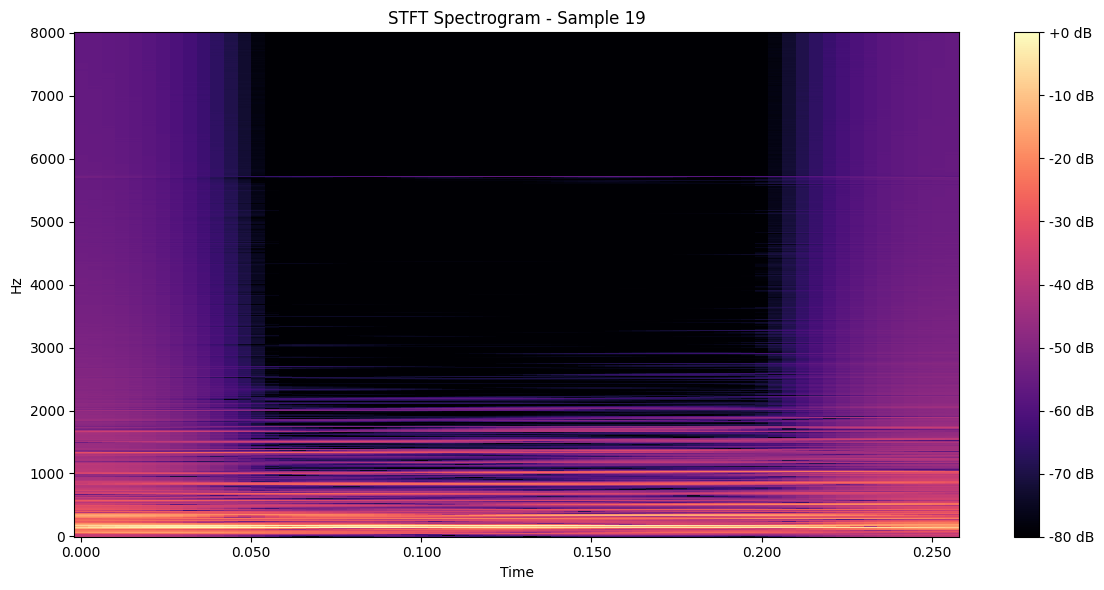

[Sample 16] No active notes.


In [16]:
sr = 16000
samples_to_plot = [10, 11, 19, 16]

def midi_to_freq(midi_note):
    return 440.0 * 2 ** ((midi_note - 69) / 12)

for idx in samples_to_plot:
  
    sample = Xtest[idx]
    labels = Ytest[idx]

    # Find active MIDI notes
    active_notes = np.where(labels == 1)[0]
    if len(active_notes) == 0:
        print(f"[Sample {idx}] No active notes.")
        continue

    # Convert MIDI notes to frequencies
    freqs = [midi_to_freq(n) for n in active_notes]
    print(f"[Sample {idx}] Active MIDI notes: {active_notes}")
    print(f"[Sample {idx}] Frequencies (Hz): {np.round(freqs, 1)}")


    n_fft = 2048
    hop_length = 64
    S = np.abs(librosa.stft(y=sample, n_fft=n_fft, hop_length=hop_length))
    S_dB = librosa.amplitude_to_db(S, ref=np.max)

    # Plot the spectrogram
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(S_dB, sr=sr, hop_length=hop_length, x_axis='time', y_axis='hz')
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'STFT Spectrogram - Sample {idx}')

    plt.tight_layout()
    plt.show()




In [18]:
sr = 16000
n_mels = 64  # Number of mel frequency bins
n_fft = 2048  # Length of FFT window
hop_length = 1024  # Number of samples between successive frames

# Optimized function to create mel spectrograms with progress bar
def create_mel_spectrograms(waveforms, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length):
    # Preallocate list for efficiency
    specs = []
    # Add progress bar for loading
    for waveform in tqdm(waveforms, desc="Generating Mel Spectrograms", unit="sample"):
        mel_spec = librosa.feature.melspectrogram(y=waveform, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibels
        specs.append(mel_spec_db)
    return np.array(specs)


Xtrain_spec = create_mel_spectrograms(Xtrain)
np.save('Xtrain_spec.npy', Xtrain_spec)  # Save 

# Function to plot statistics of mel spectrogram means
def spectrogram_stats(specs, title):
    means = np.mean(specs, axis=(1, 2))
    plt.figure(figsize=(6, 4))
    plt.hist(means, bins=50)
    plt.title(f"{title} - Mean Mel Spectrogram Intensity")
    plt.xlabel("Mean Intensity (dB)")
    plt.ylabel("Frequency")
    plt.show()

# Plot the statistics
spectrogram_stats(Xtrain_spec, "Training Mel Spectrogram Stats")

NameError: name 'Xtrain' is not defined

## Histogram of played notes

In the creating of the model we will have to take a look at unbalanced classes. Therefore I will plot some statistics about that here.

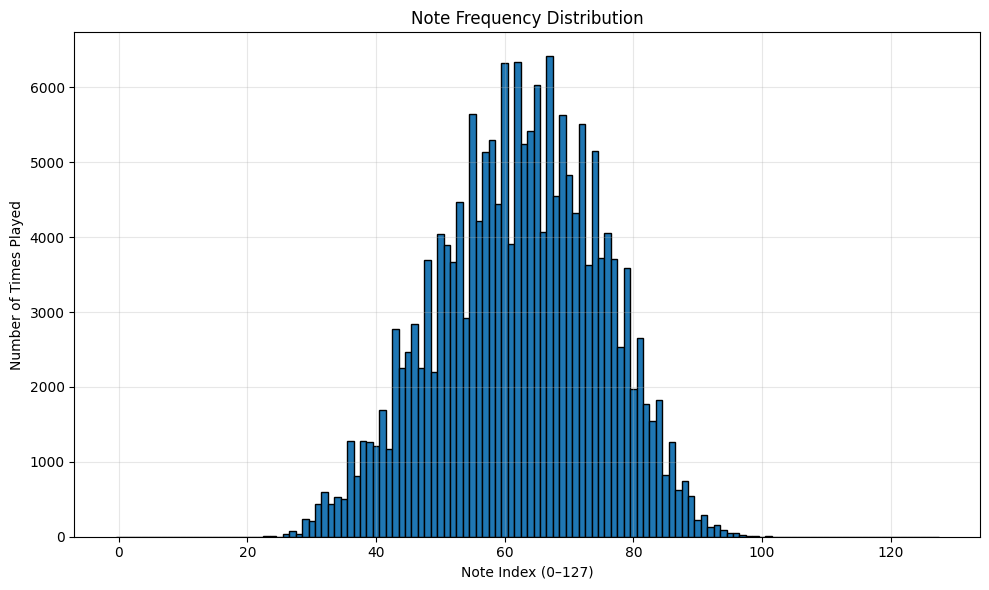

In [35]:

plt.figure(figsize=(10, 6))
plt.bar(range(128), Ytrain.sum(axis=0), width=1.0, edgecolor='black')
plt.title('Note Frequency Distribution')
plt.xlabel('Note Index (0–127)')
plt.ylabel('Number of Times Played')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


From the note frequency distribution we see that there is a class imbalance when it comes to the played notes. This means that we will have to adress this issue. Let us first get some information about distributions

In [37]:
note_counts = Ytrain.sum(axis=0)
mean_count = note_counts.mean()
std_count = note_counts.std()
median_count = np.median(note_counts)
min_count = note_counts.min()
max_count = note_counts.max()
num_zeros = np.sum(note_counts == 0)

print(f"Mean: {mean_count:.2f}")
print(f"Std: {std_count:.2f}")
print(f"Median: {median_count:.2f}")
print(f"Min: {min_count:.0f}")
print(f"Max: {max_count:.0f}")
print(f"Number of unused notes (zero count): {num_zeros}")


Mean: 1436.43
Std: 1965.24
Median: 142.00
Min: 0
Max: 6416
Number of unused notes (zero count): 48


To begin with the distribution is heavily skewed. The mean and the median are very different. Therefore, we have some notes that dominate the dataset. Forom the high standard deviation which is even bigger than the mean we conclude also that there is strong inbalance. And on top of all that there are 48 notes that are never being played. **This means we are wasting capacity trying to predict notes that never occur.**

## Overview
What we did up to this point was to read the information from the MiniNet data set, do some EDA, we showed that the data is normalized, we looked at some charactaristics of the data such as frequency ranges, mean amplitude, variance, skewness, RSM. We also explained why spectograms might be a useful way of displaying the data and how they contain more information.

# Raw data deep learning model
In this part, after examining the data for classical music that we have I am going try and train a model to transcribe the music.

## Preprocessing the data

To begin with, I am going to normalize the features so that they have a mean of 0 and a standard deviation of 1. This is an important preprocessing step when working with neural networks, as it helps improve convergence during training and ensures that the network treats all input features on a comparable scale. Without normalization, features with larger values could dominate the learning process, potentially leading to suboptimal results.

In [88]:
Xtrain_norm = (Xtrain - np.mean(Xtrain, axis=1, keepdims=True)) / np.std(Xtrain, axis=1, keepdims=True)
Xtest_norm = (Xtest - np.mean(Xtest, axis=1, keepdims=True)) / np.std(Xtest, axis=1, keepdims=True)
Xval_norm = (Xvalid - np.mean(Xvalid, axis=1, keepdims=True)) / np.std(Xvalid, axis=1, keepdims=True)


The next things we ought to do is to convert all this information into PyTorch tensors so that we can work with them. The library I am going to use is `PyTorch`.

In [89]:

# Convert to PyTorch tensors
Xtrain_tensor = torch.tensor(Xtrain_norm, dtype=torch.float32)
Ytrain_tensor = torch.tensor(Ytrain, dtype=torch.float32)
Xtest_tensor = torch.tensor(Xtest_norm, dtype=torch.float32)
Ytest_tensor = torch.tensor(Ytest, dtype=torch.float32)
Xval_tensor   = torch.tensor(Xval_norm, dtype=torch.float32)
Yval_tensor   = torch.tensor(Yvalid, dtype=torch.float32)


We use a DataLoader with TensorDataset to efficiently feed our training data to the model in manageable batches, which helps optimize memory usage and accelerates training by enabling mini-batch gradient descent. Setting shuffle=True ensures that the model sees the data in a different order each epoch, which helps prevent overfitting and improves generalization.


In [90]:
# Create DataLoaders
train_dataset = TensorDataset(Xtrain_tensor, Ytrain_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

## Building a nerual network

In this next part, I am going to start training a network to predict which notes are being played. One of the key challenges now is deciding how to structure the network and what types of layers to include. **To begin with, we will build a typical feedforward network (Multilayer Perceptron), where we progressively reduce the dimensionality of the data. We'll use ReLU activation functions to introduce non-linearity and Dropout layers to help prevent overfitting.**

This model is a simple **feedforward neural network** designed for **multi-label classification**. It takes in **flattened input vectors of size 4096**, which are assumed to represent features extracted from audio.

## Model Architecture

- **Input layer:** 4096 features — represents the flattened audio input.
- **First hidden layer:** 512 neurons with **ReLU** activation  
  - This layer reduces the high-dimensional input to a more manageable representation while capturing important patterns.
- **Dropout layer:** with a probability of 0.3 applied after the first hidden layer  
  - Helps prevent overfitting by randomly deactivating neurons during training.
- **Second hidden layer:** 256 neurons with **ReLU** activation  
  - Further compresses and refines the learned features.
- **Dropout layer:** again with probability 0.3 applied after the second hidden layer.
- **Output layer:** 128 neurons — one for each possible note in the output  
  - Each neuron predicts the probability that the corresponding note is active.
- **Sigmoid activation:** applied to each output neuron  
  - Converts raw outputs into probabilities between 0 and 1, suitable for multi-label classification.

### Loss Function

We use `BCELoss` (Binary Cross-Entropy Loss) because this is a **multi-label binary classification problem** -  
each note can independently be either active (1) or inactive (0), so the model predicts a probability for each note.

This architecture balances complexity and efficiency, providing enough capacity to learn meaningful audio feature patterns while avoiding overfitting through dropout regularization.


Before starting with the problem I am going to explain some optimizations. Since it would take a lot of repeating code to show all of the little tweaks that could be made to make the neural network most optimal I am going to record the results and explain the results I get with different optimizations. 
1. Firstly I tried by simply adding a BCELoss with no paramethers. Then I used a threshhold of 0.5 to estimate if the note has been classified correctly. This produced an F1-score of around 35% and accuracy of ...The loss treats all notes equally. Since many notes are rare, the model learns to mostly predict the common notes and ignores rare ones to minimize overall loss. Therefore, we have little false positives but some rare notes are missed more often. The results we achieved are:
| Metric           | Value   |
|------------------|---------|
| F1 Score (micro) | 0.3468  |
| Accuracy         | 0.1136  |
| Recall (micro)   | 0.2339  |
| Precision (micro)| 0.6704  |



In [93]:
# Define model
class TranscriptionModel(nn.Module):
    def __init__(self, input_size=4096, hidden_size1=512, hidden_size2=256, output_size=128):
        super(TranscriptionModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.dropout1(x)
        x = self.relu2(self.layer2(x))
        x = self.dropout2(x)
        x = self.sigmoid(self.output(x))
        return x



Epoch 1/10, Train Loss: 0.0893
Epoch 2/10, Train Loss: 0.0701
Epoch 3/10, Train Loss: 0.0672
Epoch 4/10, Train Loss: 0.0656
Epoch 5/10, Train Loss: 0.0644
Epoch 6/10, Train Loss: 0.0635
Epoch 7/10, Train Loss: 0.0628
Epoch 8/10, Train Loss: 0.0621
Epoch 9/10, Train Loss: 0.0616
Epoch 10/10, Train Loss: 0.0612


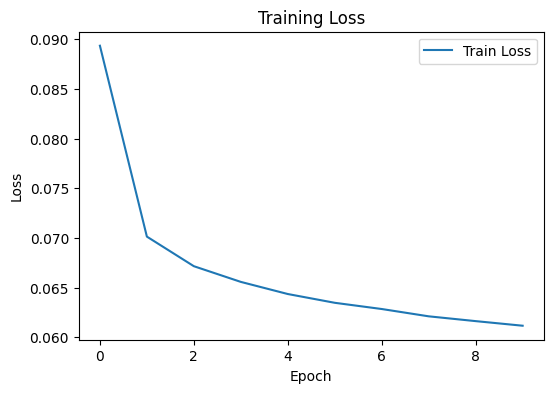

In [94]:
# Initialize model, loss, and optimizer
model = TranscriptionModel()
criterion = nn.BCELoss()  # Binary cross-entropy for multi-label
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
num_epochs = 10
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device) # trying to use the GPU is available
        optimizer.zero_grad() # not using some features that are not needed for training
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")


# Plot training history
plt.figure(figsize=(6, 4))
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

torch.save(model.state_dict(), "transcription_model.pt")

import pickle
with open("train_losses.pkl", "wb") as f:
    pickle.dump(train_losses, f)

## Evaluation


In multi-label classification tasks like music transcription, where the model predicts which notes are active in an audio frame, accuracy alone is often insufficient. This is because most notes are inactive in any given frame, so a naive model could predict all zeros and still get high accuracy.

To better understand model performance, we use the following metrics:

| Metric    | Description                                                                                           | Relevance in Music Transcription                          |
|-----------|---------------------------------------------------------------------------------------------------|----------------------------------------------------------|
| Precision | The ratio of correctly predicted active notes to all notes predicted as active.                   | Measures how many predicted notes are actually correct.  |
| Recall    | The ratio of correctly predicted active notes to all true active notes.                           | Measures how well the model finds all active notes.       |
| F1-Score  | The harmonic mean of Precision and Recall, balancing both metrics.                               | Useful when we want a balance between detecting notes and avoiding false alarms. |
| Accuracy  | The ratio of correct predictions (both active and inactive) to all predictions.                   | Can be misleading in imbalanced data like note activity. |

**Why these matter for us:**  
In music transcription, missing an active note (low recall) means the model fails to detect a real sound. Predicting too many notes that aren't actually played (low precision) means the transcription contains false notes. The F1-score helps balance these two.


In [27]:
# 2. Initialize and load the saved model state
model = TranscriptionModel()
model.load_state_dict(torch.load("transcription_model.pt", map_location='cpu'))  # or map_location=device
model.to(device)
model.eval()

# 3. Evaluate on test set
with torch.no_grad():
    Xtest_tensor = Xtest_tensor.to(device)
    outputs = model(Xtest_tensor)

    # Binarize predictions at threshold 0.5
    Ypred = (outputs > 0.5).cpu().numpy()

# 4. Calculate metrics
Ytrue = Ytest  # make sure this is in NumPy format

f1 = f1_score(Ytrue, Ypred, average='micro')
acc = accuracy_score(Ytrue, Ypred)
recall = recall_score(Ytrue, Ypred, average='micro')
precision = precision_score(Ytrue, Ypred, average='micro')

# 5. Print all metrics
print(" Evaluation Metrics on Test Set:")
print(f"F1 Score (micro):     {f1:.4f}")
print(f"Accuracy:             {acc:.4f}")
print(f"Recall (micro):       {recall:.4f}")
print(f"Precision (micro):    {precision:.4f}")

 Evaluation Metrics on Test Set:
F1 Score (micro):     0.0108
Accuracy:             0.0688
Recall (micro):       0.0055
Precision (micro):    0.7685


### Interpretation

It is extremely important now to interpret the result we got. Firstly, we need to keep in mind the fact that we are working with multiclass data. For very sparse multi-label, F1 around 0.3-0.4 is often expected unless you tune and train a lot more. 

To understand that we need to keep in mind that random guessing performs terribly. If the model predicts every label with 0.5 probability, it will often guess 50–60 positives per sample.

- But only 2 of those are actually correct.

- Precision and recall crash → F1 near 0.01–0.05

Also if we look at empirical evidence (from papers and practice) in multi-label music tagging, audio tagging, or multi-label NLP, where positives are rare:

- **Baseline F1 often sits around 0.3 to 0.4**

- **Good models with heavy tuning reach 0.5–0.6**

- **It’s very rare to go over 0.7 unless you have well-balanced data**


Considering the precision and recall independantely, we see that 2/3 f the time we classify a note correctly and 1/4 of the notes have been catched. This however is not perfect.

### Looking into examples

Now, let us go through some of the samples and see if we can get a feel of what is going on.

In [28]:

for i in range(0,20):
    mask = (model(Xtest_tensor)[i] > 0.5)
    indices = torch.nonzero(mask).squeeze().cpu().numpy()

    true_positive_indices = np.where(Ytest[i] == 1)[0]
    print(f"guess: {indices}, real: {true_positive_indices}")


guess: [], real: [62 74]
guess: [], real: [46 58 67]
guess: [], real: [62 70]
guess: [], real: [45 57 66]
guess: [], real: [62 69]
guess: [], real: [43 55 70]
guess: [], real: [62 70]
guess: [], real: [45 57 69]
guess: [], real: [62 65]
guess: [], real: [38 50 74]
guess: [], real: [38 50]
guess: [], real: [62 65 69 74]
guess: [], real: [61 64 69 76]
guess: [], real: [61 64 69 81]
guess: [], real: [62 65 69 77]
guess: [], real: [62 65 69 81]
guess: [], real: []
guess: [], real: [60 62 66 81]
guess: [], real: []
guess: [], real: [67 70 82]


We have to also get a musical understanding of the notes we are getting. We are going to make a function taking a label and transform it to a note.

In [96]:

for i in range(10, 20):
    output = model(Xtest_tensor[i].unsqueeze(0))  # [1, 128]
    pred_mask = (output > 0.5).squeeze().cpu().numpy()
    pred_indices = np.where(pred_mask == 1)[0]

    true_indices = np.where(Ytest[i] == 1)[0]

    # Set operations
    true_set = set(true_indices)
    pred_set = set(pred_indices)

    true_positives = sorted(true_set & pred_set)
    false_negatives = sorted(true_set - pred_set)
    false_positives = sorted(pred_set - true_set)

    # Convert to note names
    tp_notes = [librosa.midi_to_note(n) for n in true_positives]
    fn_notes = [librosa.midi_to_note(n) for n in false_negatives]
    fp_notes = [librosa.midi_to_note(n) for n in false_positives]

    print(f" Sample {i}")
    print(f"  True Positives (correct):   {true_positives} -> {tp_notes}")
    print(f"  False Negatives (missed):   {false_negatives} -> {fn_notes}")
    print(f"  False Positives (extra):    {false_positives} -> {fp_notes}")
    print()


 Sample 10
  True Positives (correct):   [] -> []
  False Negatives (missed):   [38, 50] -> ['D2', 'D3']
  False Positives (extra):    [62] -> ['D4']

 Sample 11
  True Positives (correct):   [65, 74] -> ['F4', 'D5']
  False Negatives (missed):   [62, 69] -> ['D4', 'A4']
  False Positives (extra):    [] -> []

 Sample 12
  True Positives (correct):   [] -> []
  False Negatives (missed):   [61, 64, 69, 76] -> ['C♯4', 'E4', 'A4', 'E5']
  False Positives (extra):    [] -> []

 Sample 13
  True Positives (correct):   [81] -> ['A5']
  False Negatives (missed):   [61, 64, 69] -> ['C♯4', 'E4', 'A4']
  False Positives (extra):    [] -> []

 Sample 14
  True Positives (correct):   [65, 77] -> ['F4', 'F5']
  False Negatives (missed):   [62, 69] -> ['D4', 'A4']
  False Positives (extra):    [] -> []

 Sample 15
  True Positives (correct):   [62, 65] -> ['D4', 'F4']
  False Negatives (missed):   [69, 81] -> ['A4', 'A5']
  False Positives (extra):    [] -> []

 Sample 16
  True Positives (correct):

What we see from that is that there are all different combinations in each of the samples. There are samples that contain no notes up to 4 notes. From our results we were able to predict a note that is contained in the true notes, however not always, with many false negatives, some true positives and rarely false possitives.

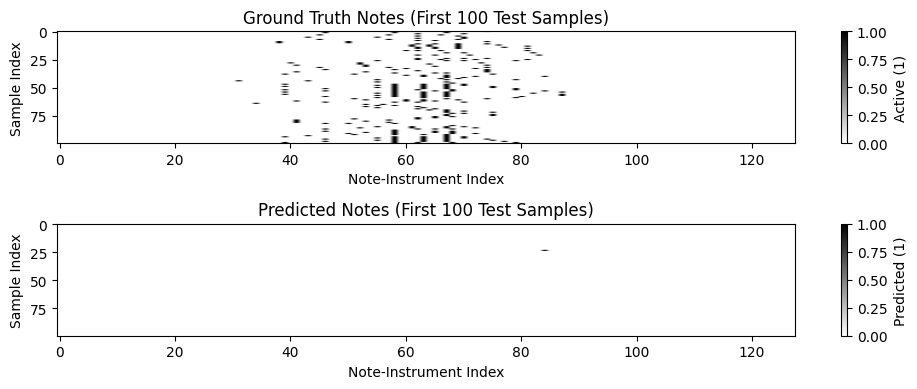

In [44]:
plt.figure(figsize=(10, 4))
plt.subplot(2, 1, 1)
plt.imshow(Ytest[:100], aspect='auto', cmap='binary')
plt.title("Ground Truth Notes (First 100 Test Samples)")
plt.xlabel("Note-Instrument Index")
plt.ylabel("Sample Index")
plt.colorbar(label="Active (1)")
plt.subplot(2, 1, 2)
plt.imshow(Ypred[:100], aspect='auto', cmap='binary')
plt.title("Predicted Notes (First 100 Test Samples)")
plt.xlabel("Note-Instrument Index")
plt.ylabel("Sample Index")
plt.colorbar(label="Predicted (1)")
plt.tight_layout()
plt.show()

## Optimization of the model

We are going to repeat some code, but this is for the sake of following the idea. **In production I would leave the best model** To begin with we are going to remove all of the unplayed notes and make the loader and dataset with the reduced data. We are going to try something which is to make the model more sensitive to notes that are. i will:
-  **Remove unused labels** (notes with zero counts).
-  **Reduce output dimension** and filtere training labels accordingly.
-  **Use Focal Loss** to handle extreme class imbalance.
-  **Adjuste prediction thresholds** to make the model more recall-sensitive.


In [74]:
used_notes_mask = note_counts > 0

# Apply mask
Ytrain_reduced_tensor = Ytrain_tensor[:, used_notes_mask]
Yval_reduced_tensor   = Yval_tensor[:, used_notes_mask]
Ytest_reduced_tensor  = Ytest_tensor[:, used_notes_mask]

# Datasets
train_dataset = TensorDataset(Xtrain_tensor, Ytrain_reduced_tensor)
val_dataset   = TensorDataset(Xval_tensor, Yval_reduced_tensor)
test_dataset  = TensorDataset(Xtest_tensor, Ytest_reduced_tensor)

# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [68]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=1.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        bce_loss = nn.BCEWithLogitsLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [70]:
class TranscriptionModel(nn.Module):
    def __init__(self, input_size=4096, hidden_size1=512, hidden_size2=256, output_size=80):
        super(TranscriptionModel, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.3)
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.dropout1(x)
        x = self.relu2(self.layer2(x))
        x = self.dropout2(x)
        x = self.output(x)
        return x


In [71]:
model = TranscriptionModel(input_size=4096, output_size=used_notes_mask.sum()).to(device)

# Compute alpha for Focal Loss
label_freq = Ytrain_reduced_tensor.sum(axis=0).cpu().numpy()
alpha = np.log1p((total - label_freq) / (label_freq + 1e-5))
alpha = torch.tensor(np.clip(alpha, 1.0, 10.0), dtype=torch.float32).to(device)


# Training function
def train_model(model, train_loader, val_loader, num_epochs, alpha, device):
    criterion = FocalLoss(alpha=alpha, gamma=1.0, reduction='mean')
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

    train_losses, val_losses, val_f1_scores = [], [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)

        model.eval()
        val_running_loss = 0.0
        all_preds, all_labels = [], []
        with torch.no_grad():
            for val_inputs, val_labels in val_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                outputs = model(val_inputs)
                loss = criterion(outputs, val_labels)
                val_running_loss += loss.item() * val_inputs.size(0)
                preds = (torch.sigmoid(outputs) > 0.3).float()  # Threshold 0.3
                all_preds.append(preds.cpu())
                all_labels.append(val_labels.cpu())
        val_loss = val_running_loss / len(val_loader.dataset)
        val_losses.append(val_loss)

        all_preds = torch.cat(all_preds)
        all_labels = torch.cat(all_labels)
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        val_f1_scores.append(f1)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Val F1: {f1:.4f}")

    return train_losses, val_losses, val_f1_scores


In [72]:
# Train model
train_losses, val_losses, val_f1s = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10,
    alpha=alpha,
    device=device
)


Epoch 1/10 | Train Loss: 0.2147 | Val Loss: 0.1843 | Val F1: 0.1667
Epoch 2/10 | Train Loss: 0.1995 | Val Loss: 0.1793 | Val F1: 0.1773


KeyboardInterrupt: 

In [ ]:
# Evaluation function
def evaluate_model(model, test_loader, valid_indices):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = (torch.sigmoid(outputs) > 0.3).float()  # Threshold 0.3
            all_preds.append(preds.cpu())
            all_labels.append(labels.cpu())
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='micro', zero_division=0)
    acc = accuracy_score(all_labels, all_preds)
    per_class_recall = precision_recall_fscore_support(all_labels, all_preds, average=None, zero_division=0)[1]

    results = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': acc,
        'per_class_recall': per_class_recall
    }
    return results


# Evaluate model
eval_results = evaluate_model(model, test_loader, valid_indices)

# Print evaluation metrics
print("\nEvaluation Metrics on Test Set (Threshold 0.3):")
print(f"Precision (micro): {eval_results['precision']:.4f}")
print(f"Recall (micro):    {eval_results['recall']:.4f}")
print(f"F1 Score (micro):  {eval_results['f1']:.4f}")
print(f"Accuracy:          {eval_results['accuracy']:.4f}")


## Trying a CNN model

In this section I am going to do some modification such as susing a CNN and also uploading the data in the form of spectograms so

# Looking at modern music

## EDA

In this second part of the project my goal is to take a look at the "babyslakh_16k" dataset which is the smaller version. I will begin by doing some EDA where I will try to understand the structure of the dataset(how long the audio files are, how many they are, what is the Hz, if they contain recordings of 1 or many different music instruent, etc.) Doing so I also aim to understand what the best way to model the dataset is as well as define a task. To begin with, we have 20 track folders containing many files. In each folder we have:
-`all_src.mid`
The original **Lakh MIDI** file containing all possible MIDI sources for that track.

-Individual MIDI stems (`S00.mid`, `S01.mid`, …)
Per-instrument MIDI files actually used to synthesize each isolated stem.  
These represent the separated MIDI data for each instrument in the mix.

-`mix.wav`
The **final mixture** created by summing all stems together.  
In **BabySlakh_16k**, this is rendered at a 16 kHz WAV format  
(in the full Slakh2100 dataset, it is stored as FLAC).

- `metadata.yaml`
    A structured metadata file describing the track, including:
    * **UUID** – Unique identifier of the original Lakh MIDI.
    * **audio_dir**, **midi_dir** – Directories for stems and MIDI files (e.g., `"stems"`, `"MIDI"`).
    * **Normalization parameters** – e.g., `normalized`, `overall_gain`.
    * **Stems metadata** – For each stem (`S00`, `S01`, …), contains:
      - `inst_class` – Instrument class.
      - `plugin_name` – Plugin used for rendering.
      - `program_num` – MIDI program number.
      - `integrated_loudness` – Loudness in LUFS.
      - `is_drum` – Boolean flag indicating whether the stem is percussion.

- `stems/` folder
Contains the **isolated audio stems** for each instrument in the track,  
rendered as individual WAV files at 16 kHz sample rate.

I am going to begin by defining a couple of function that might be useful for the analysis. Before begining I will define some constants that we are going to need. After that I am going to define a couple function.
1. Firstly, define a function that is going to get the track duration given an audio path. This will be needed so that we can find the average duration of the files.
2. Secondly, We define a function that, given a midi_folder of a track, extracts all of the pitches from all of the instruments and adds them into an array. This part could be interpreted in different ways. We could have different array, for different instruments and see which instruments are played the most compared to others and in which region they are played. However for now I will keep this simple version of tracking all of the pitches at one place
3. Define a function that uses the prior 2 functions to extract durations and pitches from all tracks.
4. Define a function that plots a histogram with given parameters.

## Hypothesis for pitch and duration
### 1. Track duration distribution

**Null Hypothesis (H₀):**  
The distribution of track durations is uniform or random without a significant central tendency around typical modern music lengths.
**Alternative Hypothesis (H₁):**  
The distribution of track durations shows a significant concentration within the typical modern music range of 3 to 5 minutes.


**Testing Approach:**  
- Use a Chi-square goodness-of-fit test to compare the observed distribution of track durations to a uniform or expected distribution.  
- Alternatively, analyze descriptive statistics such as mean, median, and confidence intervals to determine if the central tendency lies within the hypothesized range.



### 2. Pitch distribution across tracks

**Null Hypothesis (H₀):**  
Pitch values are uniformly distributed across the pitch range, indicating no preference or concentration in any register.

**Alternative Hypothesis (H₁):**  
Pitch values are significantly concentrated in the midrange registers, corresponding to typical musical instruments and vocals.

**Testing Approach:**  
- Apply a Chi-square goodness-of-fit test to compare observed pitch frequencies against a uniform distribution.  
- Perform modality tests or cluster analysis to detect and confirm significant peaks in the pitch histogram.


In [13]:
SR = 16000
BASE_FOLDER = 'babyslakh_16k'

In [14]:
def get_track_duration(audio_path):
    """Load an audio file and return its duration"""
    waveform, sr = torchaudio.load(audio_path)
    return waveform.shape[1] / sr

In [15]:
def get_pitches_from_midi(midi_folder):
    """Extract all note pitches from all MIDI files in a folder."""
    pitches = []
    midi_files = [f for f in os.listdir(midi_folder) if f.endswith('.mid')]
    
    for midi_file in midi_files:
        pm = pretty_midi.PrettyMIDI(os.path.join(midi_folder, midi_file))
        for inst in pm.instruments:
            pitches.extend([note.pitch for note in inst.notes])
    
    return pitches

In [17]:
def process_all_tracks(base_folder, track_range=range(1, 21)):
    """Go through each track folder and collect durations and pitches."""
    durations = []
    all_pitches = [] # keeping all pitches together, no matter the instrument

    for i in track_range:
        track_id = f"Track{str(i).zfill(5)}" # I am adding zeros because of the name format of the files
        track_folder = os.path.join(base_folder, track_id)

        # 1) Duration from mix.wav
        audio_path = os.path.join(track_folder, 'mix.wav')
        if os.path.exists(audio_path):
            durations.append(get_track_duration(audio_path))
        else:
            print(f"Missing audio for {track_id}")

        # 2) Pitches from MIDI files
        midi_folder = os.path.join(track_folder, 'MIDI')
        if os.path.exists(midi_folder):
            all_pitches.extend(get_pitches_from_midi(midi_folder))
        else:
            print(f"Missing MIDI for {track_id}")

    return durations, all_pitches


In [18]:
def plot_histogram(data, bins, title, xlabel, ylabel, color):
    """Plot a histogram of given data."""
    plt.hist(data, bins=bins, color=color, edgecolor='black')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


Processed 20 tracks
Average duration: 243.37 seconds
Min duration: 160.62 seconds
Max duration: 347.75 seconds
Median duration: 243.95 sec
Standard deviation: 46.13 sec


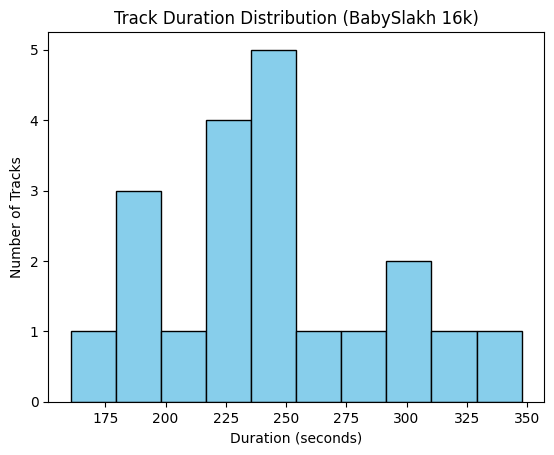

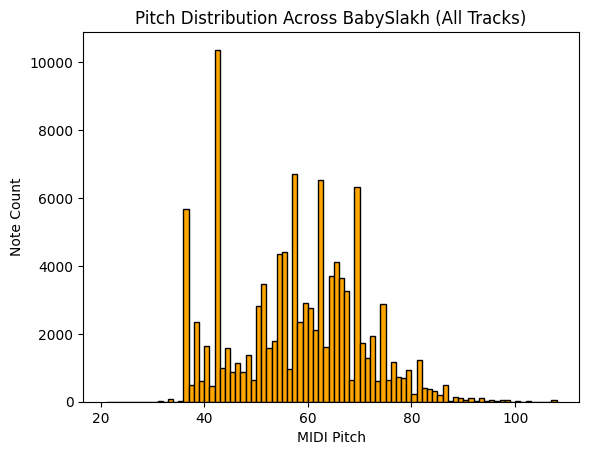

In [23]:
durations, all_pitches = process_all_tracks(BASE_FOLDER)

print(f"Processed {len(durations)} tracks")
print(f"Average duration: {np.mean(durations):.2f} seconds")
print(f"Min duration: {np.min(durations):.2f} seconds")
print(f"Max duration: {np.max(durations):.2f} seconds")
print(f"Median duration: {np.median(durations):.2f} sec")
print(f"Standard deviation: {np.std(durations):.2f} sec")

    # Duration distribution
plot_histogram(
    durations, bins=10,
    title="Track Duration Distribution (BabySlakh 16k)",
    xlabel="Duration (seconds)", ylabel="Number of Tracks",
    color="skyblue"
)

# Pitch distribution
plot_histogram(
    all_pitches, bins=np.arange(21, 109),
    title="Pitch Distribution Across BabySlakh (All Tracks)",
    xlabel="MIDI Pitch", ylabel="Note Count",
    color="orange"
)

### Track duration distribution

- To begin with, we see that the durations of almost half the files are between 220 and 255 seconds. This corresponds to about 3.7 to 4.3 minutes, which aligns well with typical modern music lengths.  
- Descriptive statistics for the 20 tracks:  
  - **Average duration:** 243.37 seconds  
  - **Median duration:** 243.95 seconds  
  - **Minimum duration:** 160.62 seconds  
  - **Maximum duration:** 347.75 seconds  
  - **Standard deviation:** 46.13 seconds  

- There are some shorter tracks (around 160–200 seconds) as well as longer ones (above 300 seconds), indicating some variety. The distribution appears to be slightly right-skewed due to these longer tracks.  
- From a preprocessing perspective, the variation in track lengths is not substantial enough to require fundamentally different handling for the shortest and longest tracks. Even though the longest track is roughly twice the duration of the shortest, this range is relatively small for most algorithms, meaning the same preprocessing pipeline can be applied consistently across all files.

### Pitch distribution across all tracks

- Firstly, we see that the histogram shows some strong peaks in certain regions:  
    - 40–50: lower register (bass, drums)  
    - 60–70: mid register (guitar, piano, vocals)  
- Few notes occur above pitch 90.  
- All this suggests that the dataset is **centered in the midrange**, which is expected.


We can **reject our null hypothesis**, seeing that the mean and median are almost the same around 4 minutes with a standard deviation of 46 seconds. This fits almost perfectly our range of 3 to 5 minutes for a song. 

Similarly, for pitch distribution, we can reject the null hypothesis of a uniform distribution. The observed pitch histogram shows distinct peaks at certain pitch ranges, indicating that some pitches occur much more frequently than others, reflecting common musical structure rather than random pitch usage.

## Extracting spectral centroid, spectral bandwidth, tempo

As for this part of the analysis I will try to extract some more important features before jumping into the modeling part.

### Spectral centroid
The spectral centroid is a key audio feature that represents the "center of mass" of the spectrum, essentially indicating where the bulk of the signal’s frequency energy is concentrated. It is often interpreted as a measure of the brightness of a sound. This would mean that if most tracks have higher spectral centroids that meens that there might be some sharper or brighter sounds. A lower spectral centroid on the other side, corresponds to darker, bass-heavy sounds.
### Spectral bandwidth
Spectral bandwidth measures the spread or range of frequencies around the spectral centroid in an audio signal. It essentially captures how wide or narrow the frequency content is distributed around the center of mass. This would suggest that a **larger spectral bandwidth** means a wider range of frequencies, meaning a more complex noisier sound. **A smaller spectral bandwitdth**  suggests narrower frequency spread, typical of pure tones or simple harmonic sounds.
### Tempo
Tempo refers to the speed or pace of a piece of music, usually measured in beats per minute (BPM). It represents how fast the underlying rhythmic pulse occurs and is a fundamental aspect of a song’s feel and style.

Now I am going to define a function which aims to extract those features from the data we have. But before doing so, let us form our hypothesis which will not be as formal for this case.
### Hypothesis

1. **Spectral Centroid** – Expected to predominantly range between **1500 Hz and 3500 Hz**, indicating generally bright tonal qualities typical of modern music.  
2. **Spectral Bandwidth** – Expected to lie between **1000 Hz and 4000 Hz**, reflecting moderate to wide timbral complexity.  
3. **Tempo (BPM)** – Expected to be mostly between **80 BPM and 130 BPM**, consistent with common tempos in popular music.


In [27]:
def extract_audio_features(base_folder, track_range=range(1, 21)):
    spectral_centroids = []
    spectral_bandwidths = []
    tempos = []

    for i in track_range:
        track_id = f"Track{str(i).zfill(5)}" # again becuase of the name formating 
        audio_path = os.path.join(base_folder, track_id, 'mix.wav')
        
        if os.path.exists(audio_path):
            y, sr = librosa.load(audio_path, sr=SR)

            # Spectral centroid
            cent = librosa.feature.spectral_centroid(y=y, sr=sr)
            spectral_centroids.append(np.mean(cent))

            # Spectral bandwidth
            bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
            spectral_bandwidths.append(np.mean(bandwidth))

            # Tempo estimation
            onset_env = librosa.onset.onset_strength(y=y, sr=sr)
            tempo = rhythm.tempo(onset_envelope=onset_env, sr=sr)
            tempos.append(tempo[0]) # The first one is the most likely

        else:
            print(f"Missing audio for {track_id}")

    return spectral_centroids, spectral_bandwidths, tempos



Having the features we will plot some important information as well as the histograms.

Spectral Centroid - Mean: 1317.32, Std: 210.74
Spectral Bandwidth - Mean: 1514.76, Std: 189.01
Tempo (BPM) - Mean: 116.66, Std: 18.51


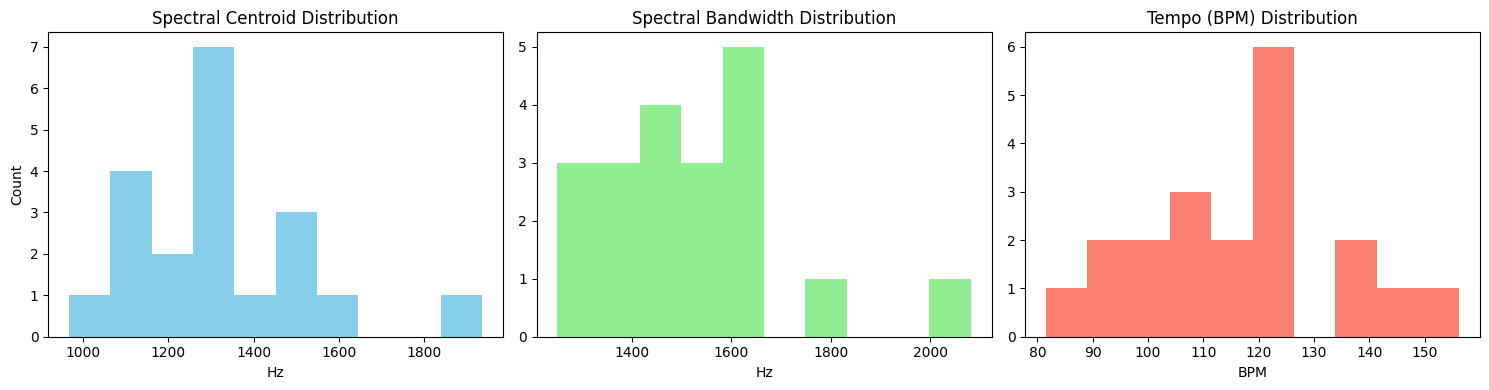

In [28]:
spectral_centroids, spectral_bandwidths, tempos = extract_audio_features(BASE_FOLDER)

spectral_centroids = np.array(spectral_centroids) # transforming them to np.arrays for easier work
spectral_bandwidths = np.array(spectral_bandwidths)
tempos = np.array(tempos)

print(f"Spectral Centroid - Mean: {np.mean(spectral_centroids):.2f}, Std: {np.std(spectral_centroids):.2f}")
print(f"Spectral Bandwidth - Mean: {np.mean(spectral_bandwidths):.2f}, Std: {np.std(spectral_bandwidths):.2f}")
print(f"Tempo (BPM) - Mean: {np.mean(tempos):.2f}, Std: {np.std(tempos):.2f}")

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.hist(spectral_centroids, bins=10, color='skyblue')
plt.title('Spectral Centroid Distribution')
plt.xlabel('Hz')
plt.ylabel('Count')

plt.subplot(1,3,2)
plt.hist(spectral_bandwidths, bins=10, color='lightgreen')
plt.title('Spectral Bandwidth Distribution')
plt.xlabel('Hz')

plt.subplot(1,3,3)
plt.hist(tempos, bins=10, color='salmon')
plt.title('Tempo (BPM) Distribution')
plt.xlabel('BPM')

plt.tight_layout()
plt.show()


### Observed Results and Comparison

1. **Spectral Centroid** – Mostly ranges from approximately **1000 Hz to 1900 Hz**, which is notably lower than expected, suggesting darker or bass-heavy tonal qualities.  
2. **Spectral Bandwidth** – Ranges from about **1300 Hz to 2100 Hz**, fitting well within the hypothesized range, indicating moderate spectral spread and consistent timbral complexity.  
3. **Tempo (BPM)** – Mainly falls between **85 BPM and 155 BPM**, aligning well with the hypothesis, though some faster outliers are present.

### Deep learning model

Now we are faced with the task of creating a model that can transcribe this music. We were able to explore a little bit about what could be useful when creating a neural network when working with audio files. However, with this task of modern music and having a different dataset with a different structure we are also faced with different problems.
### Chalanges
1. To begin with, we are working with less and longer files. This means that for the training of the model we will need separate the files into chunks.
2. Secondly, we will have to decide if we are going to treat different instruments differently or all the same.
3. After we are ready with the preprocessing we have to decide on the type of neural network we are going to use. In the last task with classical music we showed a couple of different options and discussed which one is the best for our type of problem.

## Execution plan
1. Define constants
2. Define a function that loads an audio file and converts it to mono for simplicity
3. Define a function that is computing the mel spectogram(in our earlier task we defined one but there are some other things we need to account and I am not reusing it)
4. Define a function that merges MIDI files for each track and then convert them to piano rolls so that we can use them during training.
5. Define a function that makes the data into chunks
6. Define a function that goes through the whole process using the upper functions
7. Define a function that runs through all of the tracks

### Constants, loading, mel spectogram, piano roll

We are going to define constants for easier work.

In [2]:
# Constants
SR = 16000
CHUNK_SEC = 5  # chunk length in seconds
N_MELS = 64
N_FFT = 2048
HOP_LENGTH = 1024
PITCH_RANGE = (21, 108)
PIANO_ROLL_FS = SR / HOP_LENGTH  # approx frames per second for piano roll and mel

CHUNK_FRAMES = int(CHUNK_SEC * PIANO_ROLL_FS)  # chunk length in frames


In [3]:
# Function to load audio as mono numpy array
def load_audio(audio_path, sr=SR):
    waveform, orig_sr = torchaudio.load(audio_path)
    waveform = waveform.mean(dim=0).numpy()  # mono
    if orig_sr != sr:
        waveform = librosa.resample(waveform, orig_sr, sr)
    return waveform


In [4]:
# Compute full mel spectrogram for an audio waveform
def compute_full_mel_spectrogram(audio, sr=SR, n_mels=N_MELS, n_fft=N_FFT, hop_length=HOP_LENGTH):
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=2.0
    )
    mel_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_db.T  # shape (frames, n_mels)

Unlike the task with classical music, now we are working with MIDI files and not direct labels. This means that we need to transform the MIDI files in order to get meaningful information from them for the training. Now I am going to define two functions. The first one is taking a MIDI file and transform it to a piano roll (time_steps, pitches) which are more appropriate for training. The second one is running through all the files and saving the new files as `.npy`

In [5]:
# Compute full piano roll from merged PrettyMIDI object
def compute_full_piano_roll(pm, fs=PIANO_ROLL_FS, pitch_range=PITCH_RANGE):
    pr = pm.get_piano_roll(fs=fs)  # (128, time_frames)
    min_pitch, max_pitch = pitch_range
    pr = pr[min_pitch:max_pitch+1, :]
    pr_binary = (pr > 0).astype(np.float32)
    return pr_binary.T  # (time_frames, pitches)

### Chunks and processing

In [6]:
# Chunk features into fixed-length frame chunks, pad last chunk if needed
def chunk_features(feature_array, chunk_len=CHUNK_FRAMES):
    chunks = []
    total_frames = feature_array.shape[0]
    for start in range(0, total_frames, chunk_len):
        end = start + chunk_len
        chunk = feature_array[start:end]
        if chunk.shape[0] < chunk_len:
            pad_width = ((0, chunk_len - chunk.shape[0]), (0, 0))
            chunk = np.pad(chunk, pad_width, mode='constant')
        chunks.append(chunk)
    return chunks


In [7]:

# Process one track: load, compute features, chunk, and save
def process_and_chunk_track(track_path, save_dir_mel, save_dir_pr):
    audio_path = os.path.join(track_path, "mix.wav")
    if not os.path.isfile(audio_path):
        raise FileNotFoundError(f"Audio file not found: {audio_path}")
    print(f"Loading audio from: {audio_path}")
    
    midi_folder = os.path.join(track_path, "MIDI")
    if not os.path.isdir(midi_folder):
        raise FileNotFoundError(f"MIDI folder not found: {midi_folder}")
    
    midi_files = [os.path.join(midi_folder, f) for f in os.listdir(midi_folder) if f.endswith('.mid')]
    if len(midi_files) == 0:
        raise FileNotFoundError(f"No MIDI files found in {midi_folder}")

    # Merge all MIDI files in this folder
    merged_pm = pretty_midi.PrettyMIDI()
    for midi_file in midi_files:
        pm = pretty_midi.PrettyMIDI(midi_file)
        for inst in pm.instruments:
            merged_pm.instruments.append(inst)

    # Load audio and compute features
    audio = load_audio(audio_path)
    mel_full = compute_full_mel_spectrogram(audio)
    pr_full = compute_full_piano_roll(merged_pm)

    # Align lengths by trimming to shortest length
    min_len = min(mel_full.shape[0], pr_full.shape[0])
    mel_full = mel_full[:min_len]
    pr_full = pr_full[:min_len]

    # Chunk features
    mel_chunks = chunk_features(mel_full)
    pr_chunks = chunk_features(pr_full)

    num_chunks = min(len(mel_chunks), len(pr_chunks))

    os.makedirs(save_dir_mel, exist_ok=True)
    os.makedirs(save_dir_pr, exist_ok=True)

    for i in range(num_chunks):
        mel_path = os.path.join(save_dir_mel, f"chunk_{i:03d}.npy")
        pr_path = os.path.join(save_dir_pr, f"chunk_{i:03d}.npy")
        np.save(mel_path, mel_chunks[i])
        np.save(pr_path, pr_chunks[i])
    print(f"Saved {num_chunks} chunks for track {os.path.basename(track_path)}")

### Processing the whole dataset

In [8]:
# Process all tracks in a split
def process_dataset(base_folder, track_list, split_name):
    for track in track_list:
        track_path = os.path.join(base_folder, track)
        mel_save_dir = os.path.join(base_folder, 'chunks', 'mels', split_name, track)
        pr_save_dir = os.path.join(base_folder, 'chunks', 'pianorolls', split_name, track)
        process_and_chunk_track(track_path, mel_save_dir, pr_save_dir)

# Prepare track splits and run
BASE_FOLDER = 'babyslakh_16k'  # original dataset root folder

TRACKS = [d for d in os.listdir(BASE_FOLDER) if os.path.isdir(os.path.join(BASE_FOLDER, d)) and d.startswith('Track')]
print(f"Found {len(TRACKS)} tracks")

random.seed(42)
random.shuffle(TRACKS)

num_tracks = len(TRACKS)
num_test = 2
num_val = 2
num_train = num_tracks - num_val - num_test

train_tracks = TRACKS[:num_train]
val_tracks = TRACKS[num_train:num_train + num_val]
test_tracks = TRACKS[num_train + num_val:]

print("Train tracks:", train_tracks)
print("Validation tracks:", val_tracks)
print("Test tracks:", test_tracks)

process_dataset(BASE_FOLDER, train_tracks, 'train')
process_dataset(BASE_FOLDER, val_tracks, 'val')
process_dataset(BASE_FOLDER, test_tracks, 'test')


Found 20 tracks
Train tracks: ['Track00020', 'Track00006', 'Track00015', 'Track00005', 'Track00010', 'Track00014', 'Track00016', 'Track00019', 'Track00007', 'Track00013', 'Track00018', 'Track00011', 'Track00002', 'Track00012', 'Track00003', 'Track00017']
Validation tracks: ['Track00008', 'Track00009']
Test tracks: ['Track00001', 'Track00004']
Loading audio from: babyslakh_16k\Track00020\mix.wav
Saved 69 chunks for track Track00020
Loading audio from: babyslakh_16k\Track00006\mix.wav
Saved 49 chunks for track Track00006
Loading audio from: babyslakh_16k\Track00015\mix.wav
Saved 49 chunks for track Track00015
Loading audio from: babyslakh_16k\Track00005\mix.wav
Saved 49 chunks for track Track00005
Loading audio from: babyslakh_16k\Track00010\mix.wav
Saved 36 chunks for track Track00010
Loading audio from: babyslakh_16k\Track00014\mix.wav
Saved 54 chunks for track Track00014
Loading audio from: babyslakh_16k\Track00016\mix.wav
Saved 40 chunks for track Track00016
Loading audio from: babys

### Testing for size

In [9]:
def count_and_report_chunks(base_folder):
    splits = ['train', 'val', 'test']
    
    for split in splits:
        mel_root = os.path.join(base_folder,'chunks', 'mels', split)
        pr_root = os.path.join(base_folder,'chunks', 'pianorolls', split)
        
        print(f"--- Split: {split} ---")
        
        total_mel_chunks = 0
        total_pr_chunks = 0
        mel_shapes = set()
        pr_shapes = set()
        
        tracks = sorted(os.listdir(mel_root))
        
        for track in tracks:
            mel_track_dir = os.path.join(mel_root, track)
            pr_track_dir = os.path.join(pr_root, track)
            
            if not os.path.isdir(mel_track_dir) or not os.path.isdir(pr_track_dir):
                continue
            
            mel_files = sorted([f for f in os.listdir(mel_track_dir) if f.endswith('.npy')])
            pr_files = sorted([f for f in os.listdir(pr_track_dir) if f.endswith('.npy')])
            
            total_mel_chunks += len(mel_files)
            total_pr_chunks += len(pr_files)
            
            for mf in mel_files:
                mel_array = np.load(os.path.join(mel_track_dir, mf))
                mel_shapes.add(mel_array.shape)
                
            for pf in pr_files:
                pr_array = np.load(os.path.join(pr_track_dir, pf))
                pr_shapes.add(pr_array.shape)
        
        print(f"Total mel chunks: {total_mel_chunks}")
        print(f"Unique mel shapes: {mel_shapes}")
        print(f"Total piano roll chunks: {total_pr_chunks}")
        print(f"Unique piano roll shapes: {pr_shapes}")
        print()

count_and_report_chunks(BASE_FOLDER)


--- Split: train ---
Total mel chunks: 787
Unique mel shapes: {(78, 64)}
Total piano roll chunks: 787
Unique piano roll shapes: {(78, 88)}

--- Split: val ---
Total mel chunks: 83
Unique mel shapes: {(78, 64)}
Total piano roll chunks: 83
Unique piano roll shapes: {(78, 88)}

--- Split: test ---
Total mel chunks: 94
Unique mel shapes: {(78, 64)}
Total piano roll chunks: 94
Unique piano roll shapes: {(78, 88)}



### Dataset and Dataloader
For the Dataset we have two options. We could define a custom class which loads lazily or use the TensorDataset class which is easier but loads all data in RAM. I am going to try and use the TensorDataset

In [46]:
def create_loader(mel_root_dir, pr_root_dir, batch_size=16, shuffle=True, num_workers=0):
    mel_tensors = []
    pr_tensors = []

    tracks = sorted(os.listdir(mel_root_dir))
    print(f"Loading all mel and piano roll chunks from {mel_root_dir} ...")

    for track in tqdm(tracks, desc="Tracks"):
        mel_track_dir = os.path.join(mel_root_dir, track)
        pr_track_dir = os.path.join(pr_root_dir, track)

        if not os.path.isdir(mel_track_dir) or not os.path.isdir(pr_track_dir):
            continue

        mel_chunks = sorted([f for f in os.listdir(mel_track_dir) if f.endswith('.npy')])
        pr_chunks = sorted([f for f in os.listdir(pr_track_dir) if f.endswith('.npy')])

        num_chunks = min(len(mel_chunks), len(pr_chunks))

        for i in range(num_chunks):
            mel_path = os.path.join(mel_track_dir, mel_chunks[i])
            pr_path = os.path.join(pr_track_dir, pr_chunks[i])

            mel_np = np.load(mel_path)
            pr_np = np.load(pr_path)

            # Convert to tensors, add channel dim: (1, frames, n_mels) and (1, frames, pitches)
            mel_tensor = torch.from_numpy(mel_np).float().unsqueeze(0)  # (1, frames, 64)
            pr_tensor = torch.from_numpy(pr_np).float().unsqueeze(0)    # (1, frames, 88)

            # Make frames length match by trimming to min frames
            min_frames = min(mel_tensor.shape[1], pr_tensor.shape[1])
            mel_tensor = mel_tensor[:, :min_frames, :]
            pr_tensor = pr_tensor[:, :min_frames, :]

            # Resize mel freq dim from 64 to 88 by interpolation
            # Permute to (C=1, H=64, W=frames)
            mel_tensor = mel_tensor.permute(0, 2, 1).unsqueeze(0)  # (1, 1, 64, frames)

            # Interpolate frequency dim from 64 -> 88; keep frames dim same
            mel_tensor = F.interpolate(mel_tensor, size=(88, min_frames), mode='bilinear', align_corners=False)

            # Remove batch dim and permute back to (1, frames, 88)
            mel_tensor = mel_tensor.squeeze(0).permute(0, 2, 1)

            # Now mel_tensor and pr_tensor shapes match: (1, frames, 88)
            mel_tensors.append(mel_tensor)
            pr_tensors.append(pr_tensor)

    print(f"Loaded {len(mel_tensors)} mel chunks and {len(pr_tensors)} piano roll chunks from {mel_root_dir}.")

    # Stack tensors into big tensors: (N, 1, frames, 88)
    mel_data = torch.stack(mel_tensors)
    pr_data = torch.stack(pr_tensors)

    # Create TensorDataset and DataLoader
    dataset = TensorDataset(mel_data, pr_data)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

    return loader

# Define paths
train_mel_dir = 'babyslakh_16k/chunks/mels/train'
train_pr_dir = 'babyslakh_16k/chunks/pianorolls/train'

val_mel_dir = 'babyslakh_16k/chunks/mels/val'
val_pr_dir = 'babyslakh_16k/chunks/pianorolls/val'

# Create loaders
train_loader = create_loader(train_mel_dir, train_pr_dir, batch_size=16, shuffle=True, num_workers=0)
val_loader = create_loader(val_mel_dir, val_pr_dir, batch_size=16, shuffle=False, num_workers=0)

# Example: check shapes from train loader
for mel_batch, pr_batch in train_loader:
    print("Train Mel batch shape:", mel_batch.shape)      # (batch, 1, frames, 88)
    print("Train Piano roll batch shape:", pr_batch.shape)  # (batch, 1, frames, 88)
    break

# Example: check shapes from val loader
for mel_batch, pr_batch in val_loader:
    print("Val Mel batch shape:", mel_batch.shape)      # (batch, 1, frames, 88)
    print("Val Piano roll batch shape:", pr_batch.shape)  # (batch, 1, frames, 88)
    break


Loading all mel and piano roll chunks from babyslakh_16k/chunks/mels/train ...


Tracks: 100%|██████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 17.25it/s]


Loaded 787 mel chunks and 787 piano roll chunks from babyslakh_16k/chunks/mels/train.
Loading all mel and piano roll chunks from babyslakh_16k/chunks/mels/val ...


Tracks: 100%|████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 24.72it/s]

Loaded 83 mel chunks and 83 piano roll chunks from babyslakh_16k/chunks/mels/val.
Train Mel batch shape: torch.Size([16, 1, 78, 88])
Train Piano roll batch shape: torch.Size([16, 1, 78, 88])
Val Mel batch shape: torch.Size([16, 1, 78, 88])
Val Piano roll batch shape: torch.Size([16, 1, 78, 88])


Selected random sample index: 6

Piano Roll Info (Sample 6):
Shape: (78, 88) (Frames: 78, Pitches: 88)
Number of active notes: 613
Sparsity: 0.9107 (91.07% of elements are zero)
Temporal coverage: 1.0000 (100.00% of frames have active notes)
Number of active pitches: 16 out of 88
Most active pitch (MIDI): 24 with 78 activations


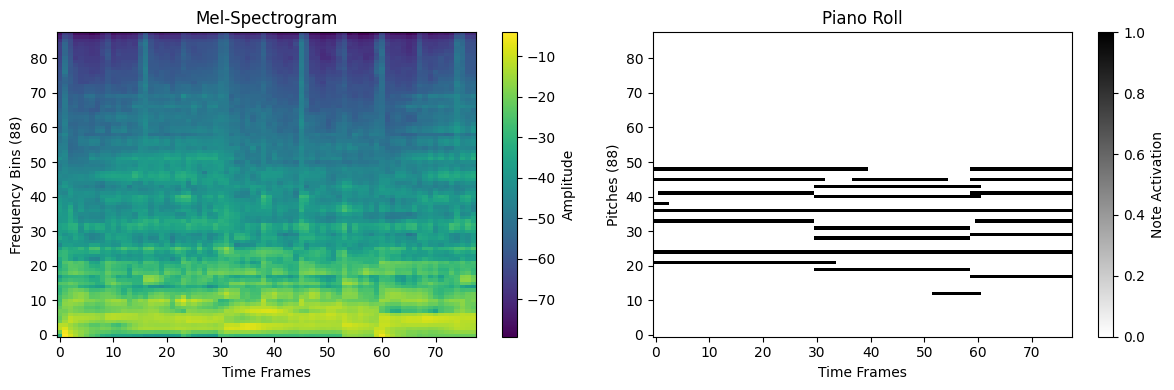

In [55]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

# Function to compute and print piano roll info
def print_pianoroll_info(mel, pr, index):
    pr_np = pr[index, 0].numpy()  # Shape: (frames, 88)
    mel_np = mel[index, 0].numpy()  # Shape: (frames, 88)

    # Compute piano roll statistics
    num_frames, num_pitches = pr_np.shape
    active_notes = np.sum(pr_np > 0.5)  # Assuming binary or near-binary (threshold at 0.5)
    sparsity = 1 - (active_notes / (num_frames * num_pitches))
    active_frames = np.sum(np.any(pr_np > 0.5, axis=1))  # Frames with at least one active note
    temporal_coverage = active_frames / num_frames
    pitch_usage = np.sum(pr_np > 0.5, axis=0)  # Number of activations per pitch
    active_pitches = np.sum(pitch_usage > 0)  # Number of unique pitches used

    # Print info
    print(f"\nPiano Roll Info (Sample {index}):")
    print(f"Shape: {pr_np.shape} (Frames: {num_frames}, Pitches: {num_pitches})")
    print(f"Number of active notes: {active_notes}")
    print(f"Sparsity: {sparsity:.4f} ({100 * sparsity:.2f}% of elements are zero)")
    print(f"Temporal coverage: {temporal_coverage:.4f} ({100 * temporal_coverage:.2f}% of frames have active notes)")
    print(f"Number of active pitches: {active_pitches} out of {num_pitches}")
    print(f"Most active pitch (MIDI): {np.argmax(pitch_usage)} with {pitch_usage[np.argmax(pitch_usage)]} activations")

    # Plot mel-spectrogram and piano roll
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot mel-spectrogram
    im1 = ax1.imshow(mel_np.T, aspect='auto', origin='lower', cmap='viridis')
    ax1.set_title('Mel-Spectrogram')
    ax1.set_xlabel('Time Frames')
    ax1.set_ylabel('Frequency Bins (88)')
    fig.colorbar(im1, ax=ax1, label='Amplitude')

    # Plot piano roll
    im2 = ax2.imshow(pr_np.T, aspect='auto', origin='lower', cmap='binary')
    ax2.set_title('Piano Roll')
    ax2.set_xlabel('Time Frames')
    ax2.set_ylabel('Pitches (88)')
    fig.colorbar(im2, ax=ax2, label='Note Activation')

    plt.tight_layout()
    plt.show()

# Get one batch from validation loader and select a random sample
for mel_batch, pr_batch in val_loader:
    batch_size = mel_batch.size(0)
    random_index = random.randint(0, batch_size - 1)  # Select random index
    print(f"Selected random sample index: {random_index}")
    print_pianoroll_info(mel_batch, pr_batch, index=random_index)
    break

## Resources
- https://www.electrical4u.com/rms-or-root-mean-square-value-of-ac-signal/
- https://en.wikipedia.org/wiki/Spectrogram
- https://www.geeksforgeeks.org/deep-learning/multi-layer-perceptron-learning-in-tensorflow/
- https://soundscapehq.com/how-long-is-the-average-song/
- https://en.wikipedia.org/wiki/Spectral_centroid#HeroSection

Found 20 tracks
Train tracks: ['Track00020', 'Track00006', 'Track00015', 'Track00005', 'Track00010', 'Track00014', 'Track00016', 'Track00019', 'Track00007', 'Track00013', 'Track00018', 'Track00011', 'Track00002', 'Track00012', 'Track00003', 'Track00017']
Validation tracks: ['Track00008', 'Track00009']
Test tracks: ['Track00001', 'Track00004']
Loading audio from: babyslakh_16k\Track00020\mix.wav
Saved 69 chunks for track Track00020
Loading audio from: babyslakh_16k\Track00006\mix.wav
Saved 49 chunks for track Track00006
Loading audio from: babyslakh_16k\Track00015\mix.wav
Saved 49 chunks for track Track00015
Loading audio from: babyslakh_16k\Track00005\mix.wav
Saved 49 chunks for track Track00005
Loading audio from: babyslakh_16k\Track00010\mix.wav
Saved 36 chunks for track Track00010
Loading audio from: babyslakh_16k\Track00014\mix.wav
Saved 54 chunks for track Track00014
Loading audio from: babyslakh_16k\Track00016\mix.wav
Saved 40 chunks for track Track00016
Loading audio from: babys